In [6]:
#load some packages for data manipulation
library(purrr)
library(magrittr)
install.packages("tidyverse")
library(tidyverse)
install.packages("scorecard")
library(scorecard)

Warning message:
"package 'purrr' was built under R version 3.6.3"
Attaching package: 'magrittr'

The following object is masked from 'package:purrr':

    set_names



package 'tidyverse' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Wanjiku Kimani\AppData\Local\Temp\RtmpUPpPu0\downloaded_packages


Warning message:
"package 'tidyverse' was built under R version 3.6.3"-- Attaching packages --------------------------------------- tidyverse 1.3.0 --
v ggplot2 3.3.2     v dplyr   1.0.2
v tibble  3.0.3     v stringr 1.4.0
v tidyr   1.1.2     v forcats 0.4.0
v readr   1.3.1     
Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'tibble' was built under R version 3.6.3"Warning message:
"package 'tidyr' was built under R version 3.6.3"Warning message:
"package 'dplyr' was built under R version 3.6.3"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x tidyr::extract()      masks magrittr::extract()
x dplyr::filter()       masks stats::filter()
x dplyr::lag()          masks stats::lag()
x magrittr::set_names() masks purrr::set_names()
also installing the dependencies 'zip', 'gridExtra', 'doParallel', 'openxlsx'



package 'zip' successfully unpacked and MD5 sums checked
package 'gridExtra' successfully unpacked and MD5 sums checked
package 'doParallel' successfully unpacked and MD5 sums checked
package 'openxlsx' successfully unpacked and MD5 sums checked
package 'scorecard' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Wanjiku Kimani\AppData\Local\Temp\RtmpUPpPu0\downloaded_packages


Warning message:
"package 'scorecard' was built under R version 3.6.3"
Attaching package: 'scorecard'

The following object is masked from 'package:tidyr':

    replace_na



In [7]:
#clear space
rm(list = ls())

In [8]:
#import data- entries with missing observations have been excluded 
data<-read.csv("Updated_credit_data.csv")

In [9]:
# Split the data into may-june orders and july orders
d<-split(data,data$delivery_month)

#select training sample (may and june) 
select_train<-d[1:2]
train<- do.call(rbind.data.frame,select_train)

#select testing sample (July)
select_test<-d[3]
test<- do.call(rbind.data.frame,select_test)


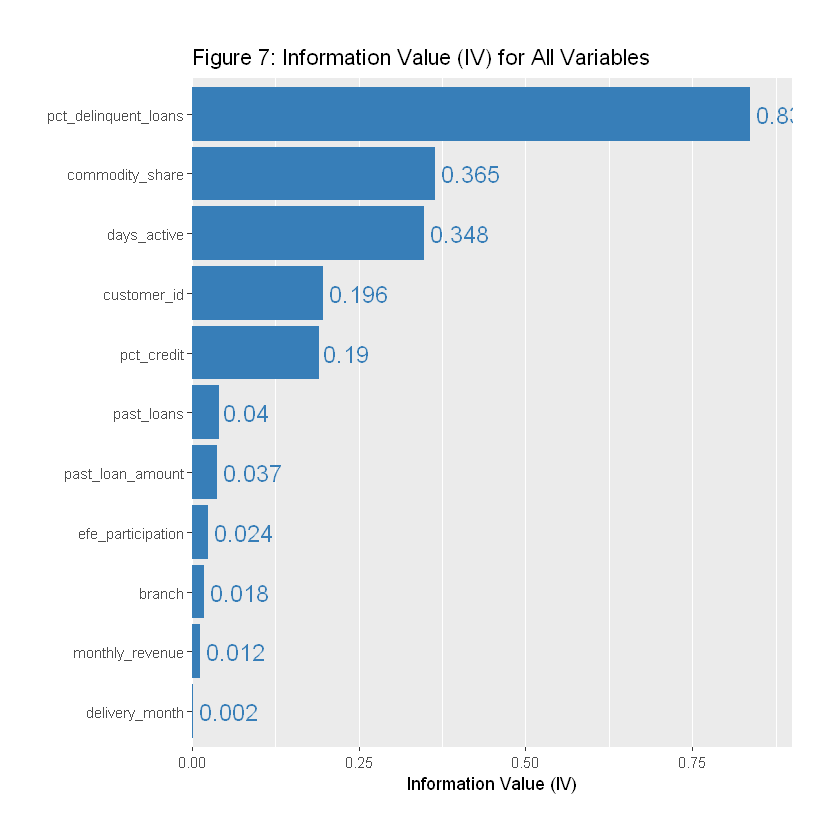

In [10]:
# Show Informational values for all variables by graph: 
info_values <- iv(train, y = "good_outcome_indicator", positive = "good_outcome_indicator|1")

info_values %>% 
  arrange(info_value) %>% 
  mutate(info_value = round(info_value, 3), variable = factor(variable, levels = variable)) %>% 
  ggplot(aes(variable, info_value)) + 
  geom_col(fill = "#377eb8") + 
  coord_flip() + 
  geom_text(aes(label = info_value), hjust = -.1, size = 5, color = "#377eb8") + 
  labs(title = "Figure 7: Information Value (IV) for All Variables", 
       x = NULL, y = "Information Value (IV)") + 
  scale_y_continuous(expand = c(0, 0), limits = c(0, 0.9)) + 
  theme(panel.grid.major.y = element_blank()) + 
  theme(plot.margin = unit(c(1, 1, 1, 1), "cm")) 

In [54]:
#Logistic regression with all variables (excluding customer_id and delivery_month)

# Only use variables with IV >= 0.01 for training Logistic Regression: 
variables_selected <- info_values %>% 
  filter(info_value >= 0.01) %>% 
  pull(1)

#Exclude customer_id in the list
variables_trunc_iv <- variables_selected[c(-4)]

# Data frame for training Logistic Regression: 
train_iv <- train %>% select(variables_trunc_iv, "good_outcome_indicator")

# Bin data set that will be used later for Logistic Regression: 
bins_var <- woebin(train_iv, y = "good_outcome_indicator", no_cores = 4, positive = "good_outcome_indicator|1")

# Creates a data frame of binned variables for Logistic Regression: 
train_woe2 <- woebin_ply(train_iv, bins_var)

# Logistic Regression:
my_logistic2 <- glm(good_outcome_indicator ~ ., family = binomial, data = train_woe2)

# Show results: 
my_logistic2 %>% summary()
  

[INFO] creating woe binning ... 
[INFO] converting into woe values ... 



Call:
glm(formula = good_outcome_indicator ~ ., family = binomial, 
    data = train_woe2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8042  -0.9417  -0.4291   1.0127   2.4308  

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -0.57759    0.07579  -7.621 2.52e-14 ***
pct_delinquent_loans_woe  0.97216    0.08558  11.360  < 2e-16 ***
commodity_share_woe       0.84084    0.32527   2.585  0.00974 ** 
days_active_woe           0.91675    0.28924   3.170  0.00153 ** 
pct_credit_woe            0.75554    0.26885   2.810  0.00495 ** 
past_loans_woe            0.07082    0.40662   0.174  0.86172    
past_loan_amount_woe      0.59655    0.31312   1.905  0.05676 .  
efe_participation_woe     0.44195    0.50769   0.871  0.38402    
branch_woe                0.28249    0.55339   0.510  0.60972    
monthly_revenue_woe       0.86054    0.26060   3.302  0.00096 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 

In [47]:
#Logistic regression with select variables that have informational value and statistical significance 

# Only use variables with IV >= 0.1 for training Logistic Regression: 
variables_selected_iv <- info_values %>% 
  filter(info_value >= 0.1) %>% 
  pull(1)

#Exclude customer_id in the list
variables_trunc <- variables_selected_iv[c(-4)]

# Data frame for training Logistic Regression: 
train_aic <- train %>% select(variables_trunc, "good_outcome_indicator")
  
# Generates optimal binning   for numerical, factor and categorical variables: 
bins_var <- woebin(train_aic, y = "good_outcome_indicator", no_cores = 20, positive = "good_outcome_indicator|1")

# Create a data frame of binned variables for Logistic Regression: 
train_woe <- woebin_ply(train_aic, bins_var)

# Logistic Regression:
my_logistic <- glm(good_outcome_indicator ~ ., family = binomial, data = train_woe)

# Show results: 
my_logistic %>% summary()


[INFO] creating woe binning ... 
[INFO] converting into woe values ... 



Call:
glm(formula = good_outcome_indicator ~ ., family = binomial, 
    data = train_woe)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5975  -0.9681  -0.4442   1.0288   2.3863  

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -0.57756    0.07507  -7.693 1.43e-14 ***
pct_delinquent_loans_woe  0.98432    0.08452  11.646  < 2e-16 ***
commodity_share_woe       0.93108    0.31886   2.920 0.003501 ** 
days_active_woe           0.99385    0.28600   3.475 0.000511 ***
pct_credit_woe            0.83915    0.26342   3.186 0.001444 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1326.9  on 1015  degrees of freedom
Residual deviance: 1105.3  on 1011  degrees of freedom
AIC: 1115.3

Number of Fisher Scoring iterations: 4


In [48]:
# Calculate scorecard scores for variables based on the results from woebin and glm: 
my_card <- scorecard(bins_var, my_logistic, points0 = 600, odds0 = 1/19, pdo = 50)

# Show Results: 

library(stringr)
do.call("bind_rows", my_card) %>% 
  slice(-1) %>% 
  select(-breaks, -is_special_values, -count, -count_distr, -good, -bad, -badprob) %>% 
  mutate_if(is.numeric, function(x) {round(x, 3)}) %>% 
  mutate(bin = bin %>% 
           str_replace_all("\\[", "From ") %>% 
           str_replace_all("\\,", " to ") %>% 
           str_replace_all("\\)", "")) -> iv_for_predictors_point

iv_for_predictors_point %>% 
  knitr::kable(col.names = c("Predictor", "Group", "WOE", "Scorecard", "Bin IV", "Total IV"))





|Predictor            |Group             |    WOE| Scorecard| Bin IV| Total IV|
|:--------------------|:-----------------|------:|---------:|------:|--------:|
|pct_delinquent_loans |From -Inf to 0.25 |  0.657|       -47|  0.275|    0.893|
|pct_delinquent_loans |From 0.25 to 0.55 | -1.172|        83|  0.179|    0.893|
|pct_delinquent_loans |From 0.55 to  Inf | -1.652|       117|  0.439|    0.893|
|commodity_share      |From -Inf to 0.4  |  0.189|       -13|  0.002|    0.053|
|commodity_share      |From 0.4 to 0.6   | -0.429|        29|  0.014|    0.053|
|commodity_share      |From 0.6 to 0.84  | -0.190|        13|  0.015|    0.053|
|commodity_share      |From 0.84 to  Inf |  0.219|       -15|  0.022|    0.053|
|days_active          |From -Inf to 45   | -0.446|        32|  0.010|    0.066|
|days_active          |From 45 to 110    |  0.219|       -16|  0.013|    0.066|
|days_active          |From 110 to 120   |  0.428|       -31|  0.015|    0.066|
|days_active          |From 120 to 135

In [50]:
# Scorecard point for all observations from train data set: 
my_points_train <- scorecard_ply(train_aic, my_card, only_total_score = FALSE, print_step = 0) %>% as.data.frame()

# Some statistics scorecard by group: 
scored_train <- train_aic %>% 
  mutate(SCORE = my_points_train$score) %>% 
  mutate(good_outcome_indicator = case_when(good_outcome_indicator == 1 ~ "Default", TRUE ~ "NonDefault")) 

scored_train %>% 
  group_by(good_outcome_indicator) %>% 
  summarise_each(funs(min, max, median, mean, n()), SCORE) %>% 
  mutate_if(is.numeric, function(x) {round(x, 0)}) %>% 
  knitr::kable(caption = "Table 1: Scorecad Points by Group for Train Data")




|good_outcome_indicator | min| max| median| mean|   n|
|:----------------------|---:|---:|------:|----:|---:|
|Default                | 324| 588|    380|  394| 365|
|NonDefault             | 318| 626|    491|  471| 651|

`summarise()` ungrouping output (override with `.groups` argument)


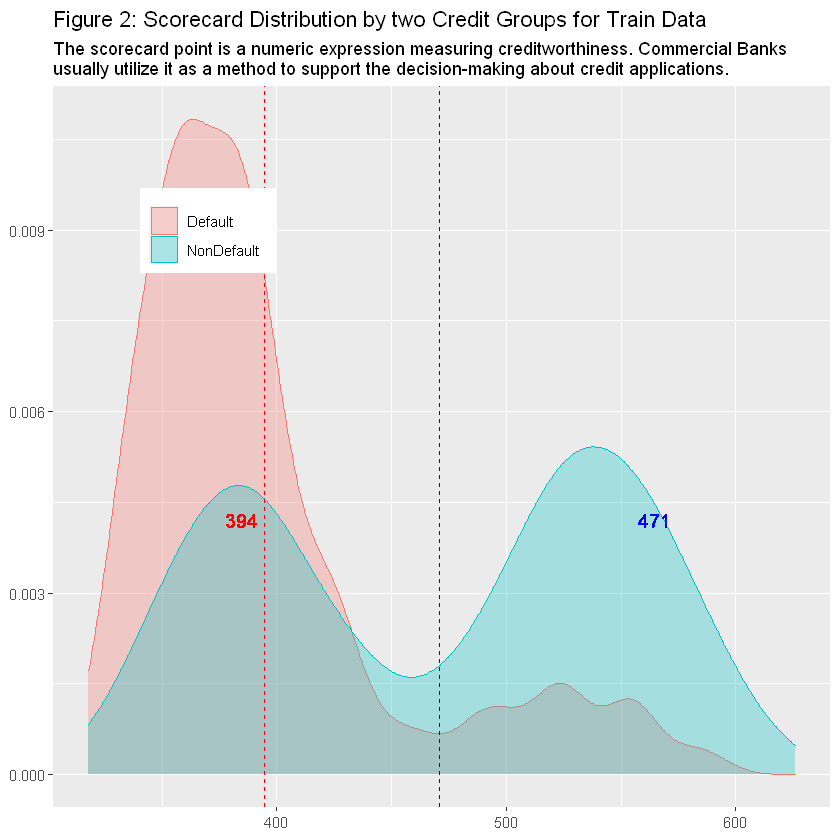

In [51]:
# Scorecard Points for train data set: 
scored_train %>% 
  group_by(good_outcome_indicator) %>% 
  summarise(tb = mean(SCORE)) %>% 
  ungroup() -> mean_score_train

scored_train %>% 
  ggplot(aes(SCORE, color = good_outcome_indicator, fill = good_outcome_indicator)) + 
  geom_density(alpha = 0.3) + 
  geom_vline(aes(xintercept = mean_score_train$tb[1]), linetype = "dashed", color = "red") + 
  geom_vline(aes(xintercept = mean_score_train$tb[2]), linetype = "dashed", color = "blue") + 
  geom_text(aes(x = 400 - 15, y = 0.0042, label = mean_score_train$tb[1] %>% round(0)), color = "red", size = 4) + 
  geom_text(aes(x = 565, y = 0.0042, label = mean_score_train$tb[2] %>% round(0)), color = "blue", size = 4) + 
  theme(legend.title = element_blank()) + 
  theme(legend.position = c(0.2, 0.8)) + 
  labs(x = NULL, y = NULL, title = "Figure 2: Scorecard Distribution by two Credit Groups for Train Data", 
       subtitle = "The scorecard point is a numeric expression measuring creditworthiness. Commercial Banks\nusually utilize it as a method to support the decision-making about credit applications.")




|good_outcome_indicator | min| max| median| mean|   n|
|:----------------------|---:|---:|------:|----:|---:|
|Default                | 318| 591|    389|  402| 151|
|NonDefault             | 327| 607|    502|  474| 564|

`summarise()` ungrouping output (override with `.groups` argument)


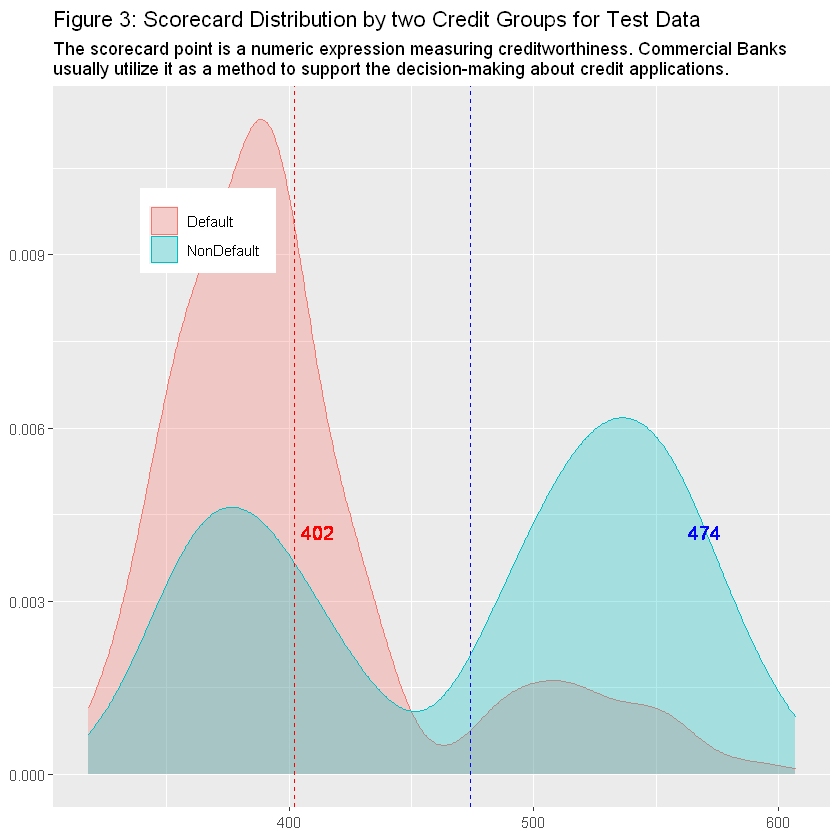

In [55]:
# Scorecard Points for test data set: 

test_aic <- test %>% select(variables_trunc, "good_outcome_indicator")

my_points_test <- scorecard_ply(test_aic, my_card, print_step = 0, 
                                only_total_score = FALSE) %>% as.data.frame()

scored_test <- test_aic %>% 
  mutate(SCORE = my_points_test$score) %>% 
  mutate(good_outcome_indicator = case_when(good_outcome_indicator == 1 ~ "Default", TRUE ~ "NonDefault")) 

scored_test %>% 
  group_by(good_outcome_indicator) %>% 
  summarise_each(funs(min, max, median, mean, n()), SCORE) %>% 
  mutate_if(is.numeric, function(x) {round(x, 0)}) %>% 
  knitr::kable(caption = "Table 2: Scorecad Points by Group for Test Data")

scored_test %>% 
  group_by(good_outcome_indicator) %>% 
  summarise(tb = mean(SCORE)) %>% 
  ungroup() -> mean_score_test

scored_test %>% 
  ggplot(aes(SCORE, color = good_outcome_indicator, fill = good_outcome_indicator)) + 
  geom_density(alpha = 0.3) + 
  geom_vline(aes(xintercept = mean_score_test$tb[1]), linetype = "dashed", color = "red") + 
  geom_vline(aes(xintercept = mean_score_test$tb[2]), linetype = "dashed", color = "blue") + 
  geom_text(aes(x = 412, y = 0.0042, label = mean_score_test$tb[1] %>% round(0)), color = "red", size = 4) + 
  geom_text(aes(x = 570, y = 0.0042, label = mean_score_test$tb[2] %>% round(0)), color = "blue", size = 4) + 
  theme(legend.title = element_blank()) + 
  theme(legend.position = c(0.2, 0.8)) + 
  labs(x = NULL, y = NULL, title = "Figure 3: Scorecard Distribution by two Credit Groups for Test Data", 
       subtitle = "The scorecard point is a numeric expression measuring creditworthiness. Commercial Banks\nusually utilize it as a method to support the decision-making about credit applications.")


[INFO] converting into woe values ... 


$binomial_metric
$binomial_metric$`Test Data`
         MSE      RMSE   LogLoss         R2        KS       AUC      Gini
1: 0.1599846 0.3999807 0.4778526 0.03963974 0.4673101 0.7374654 0.4749307


$pic
TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]


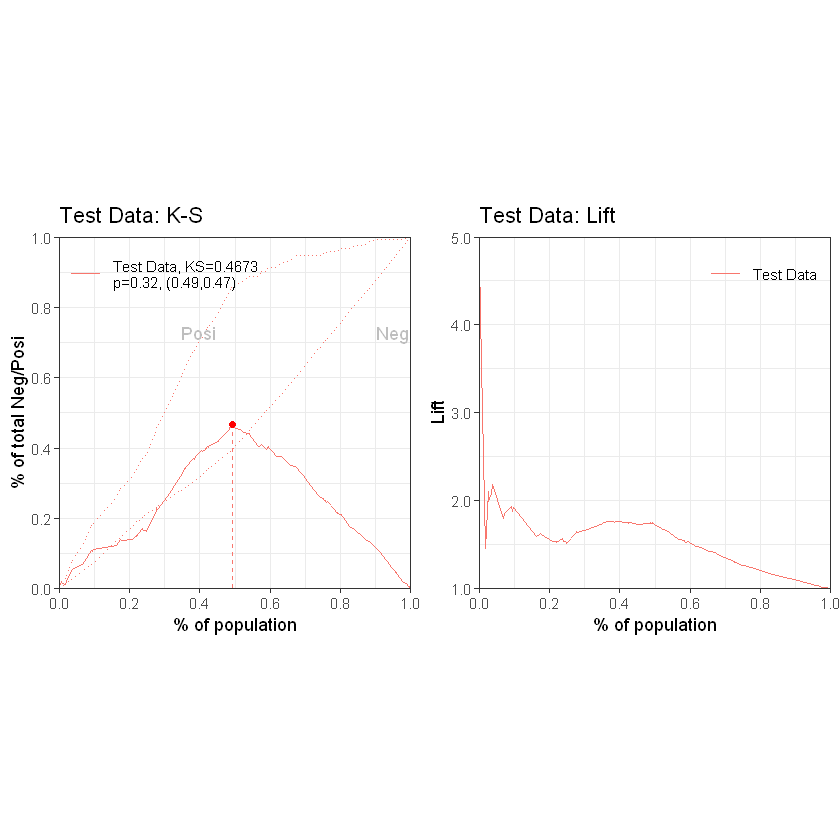

In [58]:
#Model performance 

# Convert to binned data frame for test data: 
test_woe <- woebin_ply(test_aic, bins_var)

# Caculate probabiliy of default (PD) for observations belonging test data: 
test_pred <- predict(my_logistic, test_woe, type = "response")

# Model Performance for test data: 
perf_eva(test_pred,test_aic$good_outcome_indicator, 
         type = c("ks", "roc", "lift", "pr"), 
         title = "Test Data")